In [65]:
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
import numpy as np
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
import joblib

In [66]:
data =pd.read_csv('../data/processed/mdt.csv', encoding='Latin1', index_col='id')
selected_features = pd.read_csv('../data/processed/selected_features.csv')['0'].to_list()
fraud_pipeline = joblib.load('../models/feature_engineering_pipeline.joblib')
print(selected_features)
print(data.shape)
data.head()

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'annual_inc', 'addr_state', 'dti', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt']
(38480, 27)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,repay_fail
id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,36 months,0.00,0.00,< 1 year,RENT,0.0,Not Verified,...,0.0,0.0,0.0,1.0,0.000000,0.00,0.00,0.00,0.00,1
545583,2500.0,2500.0,2500.0,36 months,13.98,85.42,4 years,RENT,20004.0,Not Verified,...,0.0,981.0,21.3,10.0,3075.291779,3075.29,2500.00,575.29,90.85,0
532101,5000.0,5000.0,5000.0,36 months,15.95,175.67,4 years,RENT,59000.0,Not Verified,...,0.0,18773.0,99.9,15.0,2948.760000,2948.76,1909.02,873.81,175.67,1
877788,7000.0,7000.0,7000.0,36 months,9.91,225.58,10+ years,MORTGAGE,53796.0,Not Verified,...,0.0,3269.0,47.2,20.0,8082.391880,8082.39,7000.00,1082.39,1550.27,0
875406,2000.0,2000.0,2000.0,36 months,5.42,60.32,10+ years,RENT,30000.0,Not Verified,...,0.0,0.0,0.0,15.0,2161.663244,2161.66,2000.00,161.66,53.12,0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['repay_fail'], axis=1), # predictive variables
    data['repay_fail'], # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=0, # we are setting the seed here
)

X_train.shape, X_test.shape

((34632, 26), (3848, 26))

In [68]:
X_train_transformed = fraud_pipeline.transform(X_train)
X_test_transformed = fraud_pipeline.transform(X_test)

In [69]:
from sklearn import model_selection
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    models = [
            ('LogReg', LogisticRegression()), 
            ('RF', RandomForestClassifier()),
            ('KNN', KNeighborsClassifier()),
           # ('SVM', SVC()), 
            ('GNB', GaussianNB()),
            ('XGB', XGBClassifier(objective= "binary:logistic",eval_metric = "mlogloss",use_label_encoder=False))
            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['No Default', 'Default']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_prob = clf.predict_proba(X_test)[:, 1]

        # Calcula el ROC-AUC con diferentes umbrales
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)

        # Encuentra el umbral óptimo que maximiza el AUC
        optimal_threshold_index = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_threshold_index]

        y_pred = (y_prob >= optimal_threshold).astype(int)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        this_df['optimize_threshold'] = optimal_threshold
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [70]:
data = run_exps(X_train_transformed, y_train.values.ravel(), X_test_transformed, y_test.values.ravel())

LogReg
              precision    recall  f1-score   support

   No Fraude       0.99      0.99      0.99      3240
      Fraude       0.93      0.97      0.95       608

    accuracy                           0.98      3848
   macro avg       0.96      0.98      0.97      3848
weighted avg       0.98      0.98      0.98      3848

RF
              precision    recall  f1-score   support

   No Fraude       0.99      0.98      0.99      3240
      Fraude       0.92      0.97      0.94       608

    accuracy                           0.98      3848
   macro avg       0.96      0.98      0.97      3848
weighted avg       0.98      0.98      0.98      3848

KNN
              precision    recall  f1-score   support

   No Fraude       0.95      0.73      0.82      3240
      Fraude       0.35      0.78      0.48       608

    accuracy                           0.73      3848
   macro avg       0.65      0.75      0.65      3848
weighted avg       0.85      0.73      0.77      3848

GNB
 

In [71]:
bootstraps = []

for model in list(set(data.model.values)):
    model_df = data.loc[data.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [72]:
bootstrap_df[bootstrap_df['test_roc_auc'] == bootstrap_df['test_roc_auc'].max()]

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model,optimize_threshold
92,0.244904,0.017759,0.994658,0.994676,0.994658,0.99462,0.999468,XGB,0.069176
95,0.244904,0.017759,0.994658,0.994676,0.994658,0.99462,0.999468,XGB,0.069176
97,0.244904,0.017759,0.994658,0.994676,0.994658,0.99462,0.999468,XGB,0.069176
99,0.244904,0.017759,0.994658,0.994676,0.994658,0.99462,0.999468,XGB,0.069176
102,0.244904,0.017759,0.994658,0.994676,0.994658,0.99462,0.999468,XGB,0.069176
105,0.244904,0.017759,0.994658,0.994676,0.994658,0.99462,0.999468,XGB,0.069176
112,0.244904,0.017759,0.994658,0.994676,0.994658,0.99462,0.999468,XGB,0.069176
113,0.244904,0.017759,0.994658,0.994676,0.994658,0.99462,0.999468,XGB,0.069176
117,0.244904,0.017759,0.994658,0.994676,0.994658,0.99462,0.999468,XGB,0.069176


Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

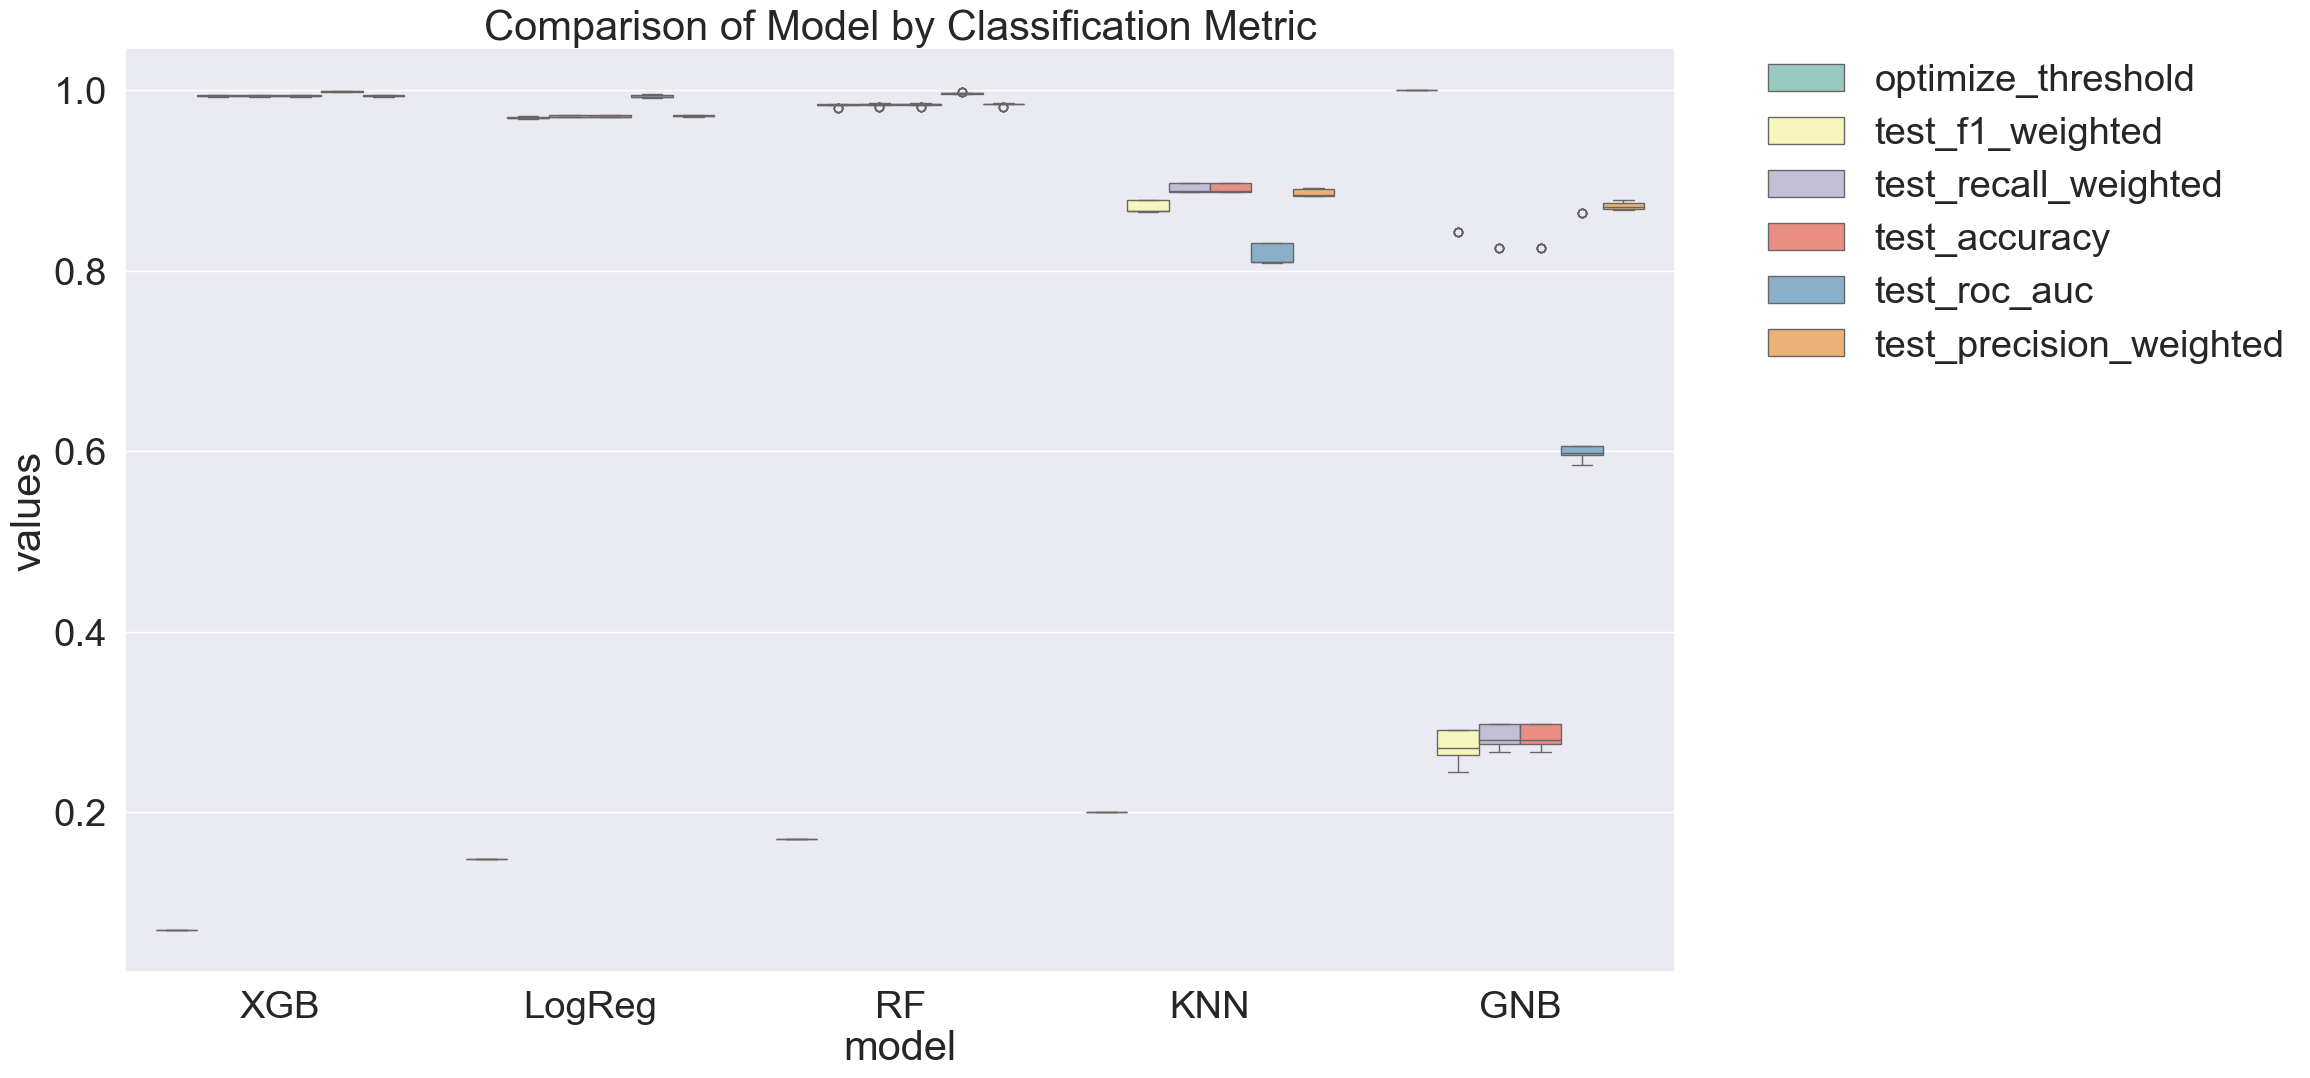

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')

Text(0.5, 1.0, 'Comparison of Model by Fit and Score Time')

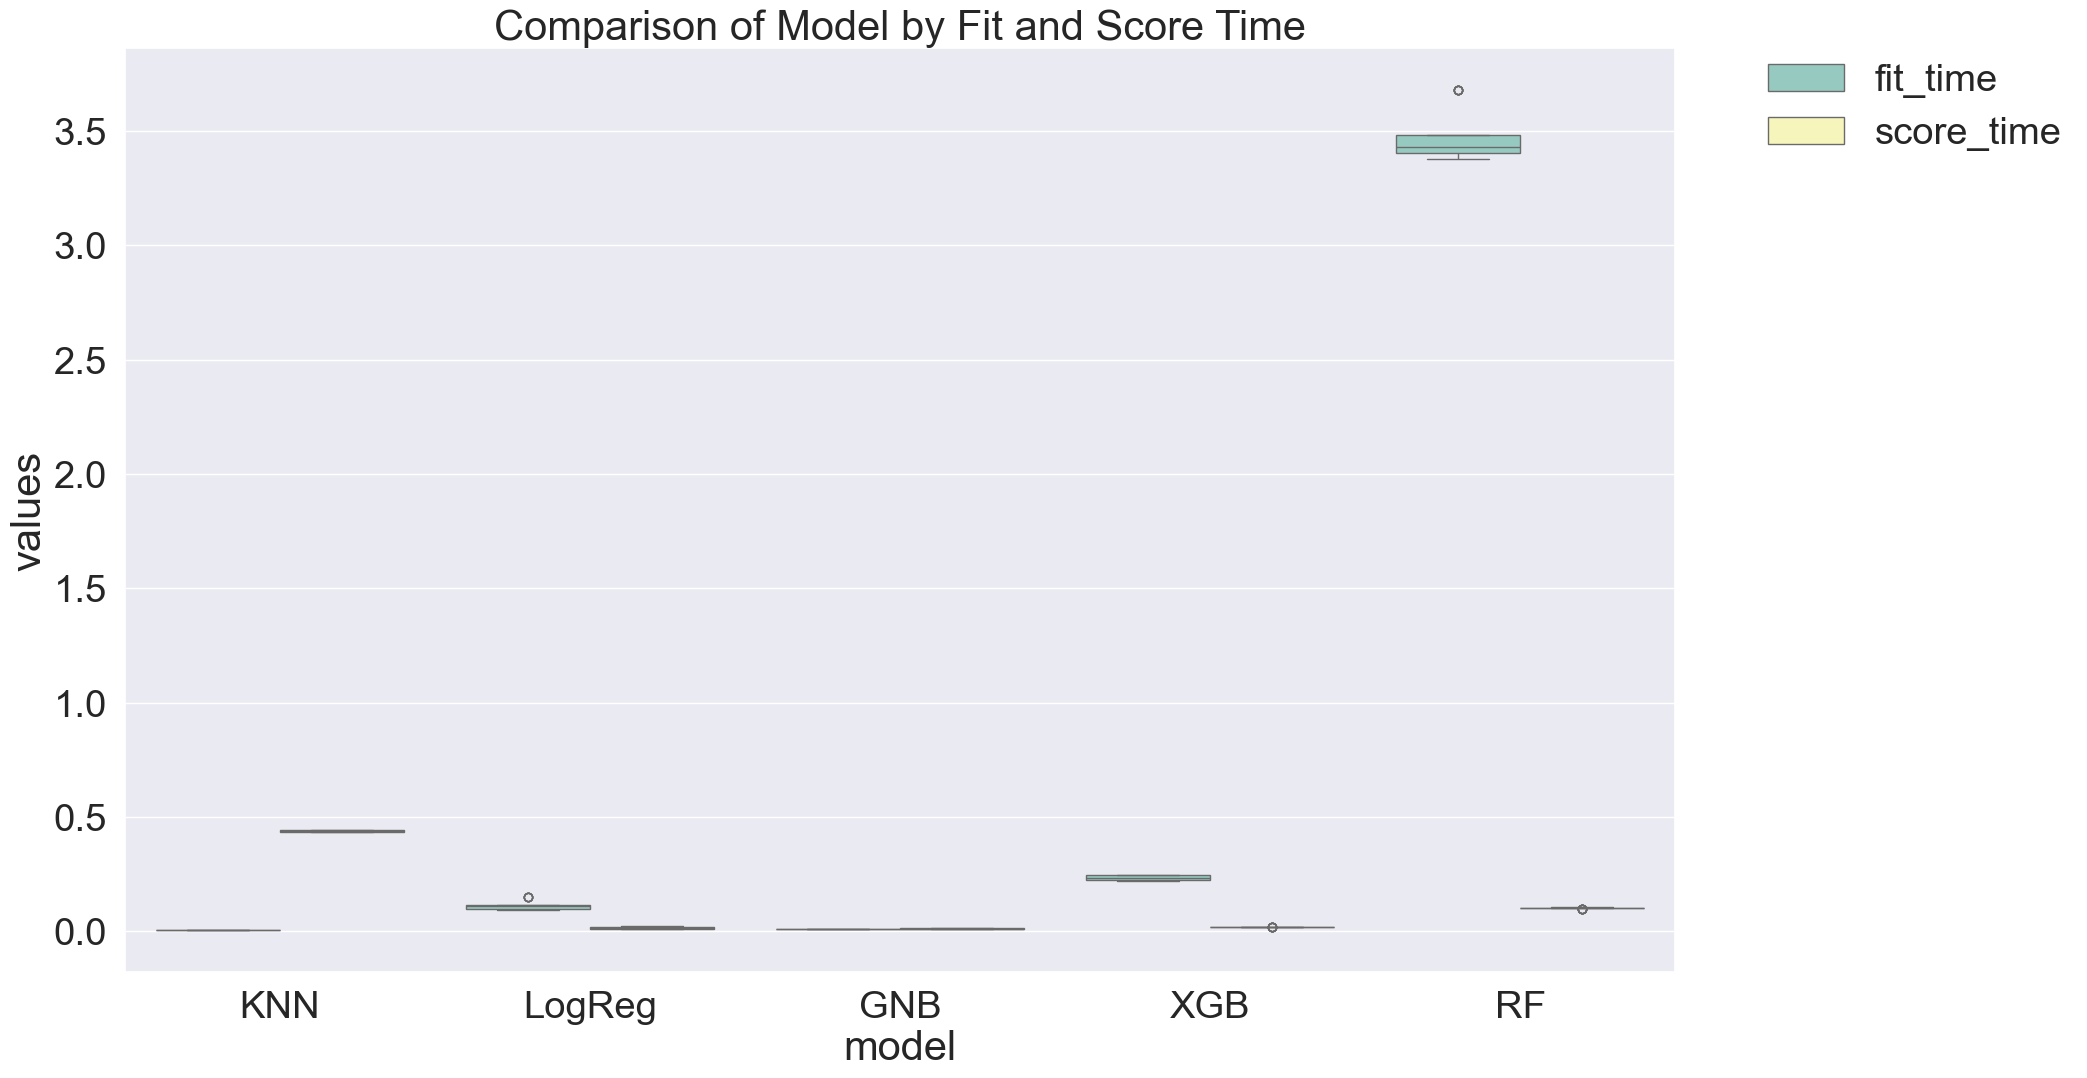

In [74]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')

Me quedo con el XGB

In [75]:
clf = XGBClassifier()
clf.fit(X_train_transformed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [76]:
preds_test = clf.predict_proba(X_test_transformed)[:, 1]

In [77]:
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

y_pred = (preds_test >= optimal_threshold).astype(int)

In [78]:
optimal_threshold

0.0691764

In [79]:
confusion_matrix(y_test, y_pred)

array([[3223,   17],
       [  12,  596]])

In [80]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3240
           1       0.97      0.98      0.98       608

    accuracy                           0.99      3848
   macro avg       0.98      0.99      0.99      3848
weighted avg       0.99      0.99      0.99      3848



In [81]:
roc_auc_score(y_test, preds_test)

0.9987562946718649

In [82]:
fraud_pipeline.steps.append(('model', clf))

In [83]:
joblib.dump(fraud_pipeline, '../models/final_pipeline.joblib')

['../models/final_pipeline.joblib']

In [88]:
importances = clf.feature_importances_


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

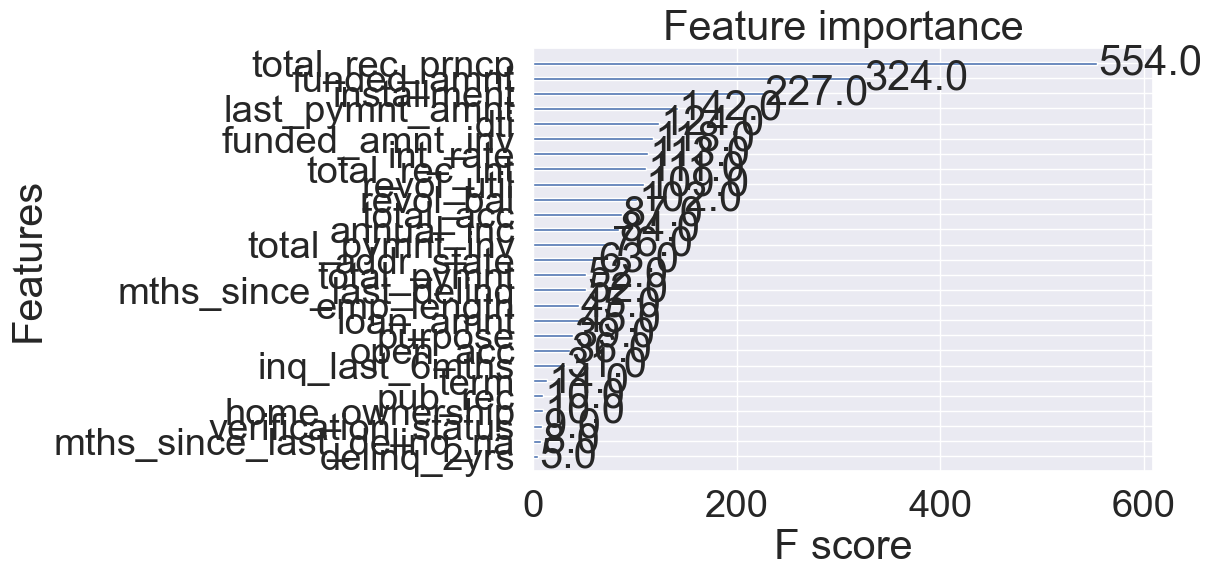

In [90]:
xgb.plot_importance(clf)

In [91]:
data

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model,optimize_threshold
0,0.117259,0.017459,0.970261,0.971227,0.970261,0.968982,0.994466,LogReg,0.148621
1,0.095792,0.009619,0.970406,0.971178,0.970406,0.969177,0.991826,LogReg,0.148621
2,0.148824,0.022789,0.970113,0.971037,0.970113,0.968804,0.992621,LogReg,0.148621
3,0.113153,0.011484,0.972278,0.973005,0.972278,0.971044,0.992660,LogReg,0.148621
4,0.100039,0.016321,0.972278,0.972922,0.972278,0.971097,0.995894,LogReg,0.148621
5,3.676645,0.103646,0.984409,0.984692,0.984409,0.984074,0.996479,RF,0.170000
6,3.430167,0.102796,0.984842,0.985064,0.984842,0.984534,0.997192,RF,0.170000
7,3.479479,0.105623,0.981375,0.981748,0.981375,0.980888,0.996743,RF,0.170000
8,3.403761,0.098227,0.984262,0.984520,0.984262,0.983879,0.996499,RF,0.170000
9,3.378003,0.101593,0.985562,0.985801,0.985562,0.985241,0.998612,RF,0.170000
